## L3: Topic Models
### 732A92/TDDE16 Text Mining
Måns Magnusson

The purpose of this lab is to implement the standard Gibbs sampling algorithm for Latent Dirichlet Allocation in Python. You will be supplied starter code, a smaller corpus with State of the Union addresses for the period 1975 to 2000 by paragraph and a list with English stopwords. The code is implemented as a class, TopicModel, where you are expected to replace central parts of the code with your own implementations.

### 1. Sampling

Implement the basic collapsed Gibbs sampling algorithm for Latent Dirichlet Allocation. Use the starter code and add the components that is missing (the sampler part). We use the fact that 

$$p(z_{i}=k)\propto\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\sum^{V}\left(\beta+n_{k,w_{i}}^{(w)}\right)}=\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{V\beta+n_{k}}$$

to simplify computations, where $K$ is the number of topics, $V$ is the vocabulary size and $D$ is the number of documents. $\mathbf{n}^{(d)}$ is a count matrix of size $D\times K$ with the number of topic indicators by document, $d$, and topic $k$, $\mathbf{n}^{(w)}$ is a count matrix of size $K\times V$ with the number of topic indicators by topic, $k$, and word type, $w$. $\mathbf{n}$ is a topic indicator count vector of length $K$ that contain the number of topic indicators in each topic. The detailed algorithm can be found below:

__Data:__ tokenized corpus $\mathbf{w}$, priors $\alpha, \beta$ <br>
__Result:__ topic indicators $\mathbf{z}$

Init topic indicators $\mathbf{z}$ randomly per token<br>
Init topic probability vector $\mathbf{p}$<br>
Sum up $\mathbf{z}$ to $\mathbf{n}^{w}$, the topic type count matrix of size ($K \times V$)<br>
Sum up $\mathbf{z}$ to $\mathbf{n}^{d}$, the document topic count matrix of size ($D \times K$)<br>
Sum up $\mathbf{z}$ to $\mathbf{n}$, the topic count vector of length ($K$)<br>

for $g \leftarrow 1$ __to__ _no_\__iterations_ __do__<br>
&emsp;&emsp;// Iterate over all tokens<br>
&emsp;&emsp;for $i \leftarrow 1$ __to__ $N$ __do__<br>
&emsp;&emsp;&emsp;&emsp;// Remove current topic indicator $z_i$ from $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ =- 1, $n^{(d)}_{d_i,z_i}$ =- 1, $n_{z_i}$ =- 1<br>
&emsp;&emsp;&emsp;&emsp;for $k \leftarrow 1$ __to__ $K$ __do__<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;// Compute the unnormalized probability of each topic indicator<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\mathbf{p}_k \leftarrow \left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\left(V\beta+n_{k}\right)}$<br>
&emsp;&emsp;&emsp;&emsp;__end__<br>
&emsp;&emsp;&emsp;&emsp;// Sample the topic indicator<br>
&emsp;&emsp;&emsp;&emsp;$z_i \leftarrow $ Categorical($\mathbf{p}$)<br>
&emsp;&emsp;&emsp;&emsp;// Add the new topic indicator $z_i$ to $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ =+ 1, $n^{(d)}_{d_i,z_i}$ =+ 1, $n_{z_i}$ =+ 1<br>
&emsp;&emsp;__end__<br>
__end__

For a complete derivation of the collapsed Gibbs sampler for LDA, see https://lingpipe.files.wordpress.com/2010/07/lda3.pdf.

In [1]:
import numpy, random, scipy.special
from tm3 import LDAGibbs

class MyGibbs(LDAGibbs):
    
    def initialize_matrices(self):
        """Initializes numpy arrays for the matrix computations performed
        by the sampler during the MCMC process."""
        ## Set up numpy matrices
        self.term_topics = numpy.zeros((self.num_terms, self.num_topics))
        self.doc_topics = numpy.zeros((self.num_docs, self.num_topics))
        self.topic_totals = numpy.zeros(self.num_topics)
        self.doc_totals = numpy.zeros(self.num_docs)
        ## Initialize topics randomly
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            ## Create an array of random topic assignments
            doc['topics'] = list(map(lambda x: random.randrange(self.num_topics), doc['tokens']))
            ## Construct the initial summary statistics
            doc_length = len(doc['tokens'])
            for i in range(doc_length):
                token = doc['tokens'][i]
                topic = doc['topics'][i]
                self.term_topics[token][topic] += 1 # n_wk
                self.doc_topics[doc_id][topic] += 1 # n_dk
                self.topic_totals[topic] += 1       # n_k
                self.doc_totals[doc_id] += 1
        ## Printout to check that everything is coherent
#         print(sum(sum(self.doc_topics)))
#         print(sum(sum(self.term_topics)))
#         print(sum(self.topic_totals))
#         print(sum(self.doc_totals))
    
    def read_documents(self, filename):
        """Reads documents from a file, filters stop words and initializes
        the vocabulary. Also converts tokens to integer term IDs."""
        self.total_tokens = 0
        self.vocab = []
        self.vocab_ids = {}
        with open(filename) as f:
            for line in f:
                line = line.replace(".", " ").replace(",", " ").lower()
                self.num_docs += 1
                tokens = []
                for w in line.split():
                    if not w in self.stoplist:
                        self.total_tokens += 1
                        if w in self.vocab_ids:
                            tokens.append(self.vocab_ids[w])
                        else:
                            term_id = len(self.vocab)
                            self.vocab.append(w)
                            self.vocab_ids[w] = term_id
                            tokens.append(term_id)
                self.doc_snippets.append(line[:200])
                self.docs.append({ 'tokens': tokens })
        self.num_terms = len(self.vocab)
        print("Read {} documents with a total of {} terms".format(self.num_docs, self.num_terms))
    
    def __init__(self,
                 num_topics,
                 docs_file_name,
                 stop_list_file_name = None):
        self.num_topics = num_topics
        self.num_docs = 0
        self.doc_snippets = []
        self.docs = []
        ## Prepare list of stopwords
        self.stoplist = dict()
        if stop_list_file_name != None:
            with open(stop_list_file_name) as f:
                for line in f:
                    word = line.rstrip()
                    self.stoplist[word] = 1
        self.read_documents(docs_file_name)
        self.initialize_matrices()
    
    def print_topics(self, j):
        """Prints topic distributions for the."""
        n_w_t = numpy.array(self.term_topics).T

        for topic in range(self.num_topics):
            term_ids = numpy.argsort(n_w_t[topic])[::-1][:j]
            values = numpy.sort(n_w_t[topic])[::-1][:j]
            for term, value in zip(term_ids, values):
                print('{} [{}]'.format(self.vocab[term], value), end=' ')
            print()
            
    def make_draw(self, alpha, beta):
        """Makes a single draw from the posterior distribution in an MCMC fashion."""
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            tokens = doc['tokens']
            topics = doc['topics']
            for i in range(len(tokens)):
                token = tokens[i]
                topic = topics[i]
                self.term_topics[token][topic] -= 1 # n_w
                self.doc_topics[doc_id][topic] -= 1 # n_d
                self.topic_totals[topic] -= 1       # n

                p = numpy.zeros(self.num_topics)
                for k in range(self.num_topics):
                    p[k] = (alpha + self.doc_topics[doc_id][k]) * (beta + self.term_topics[token][k]) / (len(self.vocab) * beta + self.topic_totals[k])

                p_norm = p / sum(p)
                z_i = numpy.flatnonzero(numpy.random.multinomial(1, p_norm))[0]
                topics[i] = z_i

                self.term_topics[token][z_i] += 1 # n_w
                self.doc_topics[doc_id][z_i] += 1 # n_d
                self.topic_totals[z_i] += 1       # n
    
    def compute_logprob(self, alpha, beta):
        """Computes the log marginal posterior."""
        return super().compute_logprob(alpha, beta)
    
    def run(self, num_iterations = 50, alpha = 0.1, beta = 0.01):
        self.logprobs = []
        for iteration in range(num_iterations):
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            self.logprobs.append(logprob)
            print("iteration {}, {}".format(iteration, logprob))
            
    def plot(self):
        super().plot()
        
    def new_speech(self, topic, doc_length):
        # Sample a row 
        sample = numpy.random.dirichlet(self.term_topics.T[topic] + 0.5)
        print('Topic:', topic)
        for i in range(doc_length):
            # From the topic sample, draw a word
            word_id = numpy.flatnonzero(numpy.random.multinomial(1, sample))[0]
            print(self.vocab[word_id], end=' ')
        print()
    

Implement the make_draw function above. You should get behavior very similar to the results from calling the parent class.

In [2]:
model = MyGibbs(10, 'sotu_1975_2000.txt', 'stoplist_en.txt')
model.run(60)

Read 2898 documents with a total of 8695 terms
iteration 0, -10.369228100069718
iteration 1, -9.853709985762704
iteration 2, -9.580165103284932
iteration 3, -9.42392373726779
iteration 4, -9.316593360340654
iteration 5, -9.233235410447872
iteration 6, -9.15090401220772
iteration 7, -9.09298353779537
iteration 8, -9.036095400847156
iteration 9, -8.995413365064579
iteration 10, -8.955300705509218
iteration 11, -8.928480960638462
iteration 12, -8.89689702971096
iteration 13, -8.87251069977787
iteration 14, -8.849935654919637
iteration 15, -8.821967577988792
iteration 16, -8.80562506375255
iteration 17, -8.785271615897443
iteration 18, -8.766247392012334
iteration 19, -8.75136444340813
iteration 20, -8.729330904679026
iteration 21, -8.714745833630914
iteration 22, -8.700861985279921
iteration 23, -8.68705526039851
iteration 24, -8.674017816894917
iteration 25, -8.663928320801263
iteration 26, -8.653574785938957
iteration 27, -8.640614475063447
iteration 28, -8.62683809676078
iteration 29, 

### 2. Top terms
Implement the print_topics function to extract the top j largest counts in n (w) by row. This is the most probable word types in each topic.

In [3]:
model.print_topics(10)

world [241.0] america [183.0] peace [166.0] war [107.0] security [89.0] years [79.0] strong [78.0] country [77.0] defense [77.0] people [74.0] 
children [127.0] education [116.0] america [104.0] schools [96.0] congress [95.0] school [75.0] president [65.0] american [63.0] mr [60.0] good [58.0] 
soviet [143.0] states [142.0] united [139.0] world [126.0] nations [110.0] economic [94.0] international [93.0] countries [88.0] security [71.0] policy [71.0] 
budget [209.0] tax [198.0] years [197.0] year [183.0] percent [155.0] spending [135.0] growth [126.0] jobs [115.0] million [113.0] federal [108.0] 
nation [149.0] government [112.0] rights [80.0] economic [79.0] great [79.0] economy [73.0] america [72.0] americans [64.0] ve [57.0] union [56.0] 
people [239.0] work [213.0] americans [133.0] welfare [119.0] american [112.0] time [101.0] america [101.0] years [100.0] tonight [98.0] make [90.0] 
world [149.0] america [112.0] freedom [109.0] free [101.0] people [89.0] american [88.0] make [73.

### 3. Explore the data

Run your implemention on the State of the Union corpus until convergence with 10 topics, don't forget to remove stop words. Plot the log marginal posterior by the number of iterations. How many iterations do you need until convergence? How do you interpret the topics?

[Hint: You can use the plot-function to print the marginal probability for each iteration. To get it working in Jupyter you need to run the command `%matplotlib inline` before plotting the first time.]

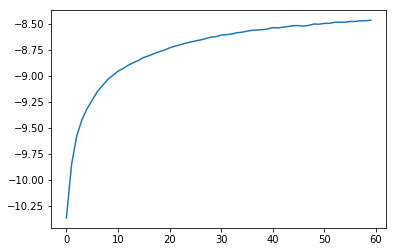

In [4]:
%matplotlib inline
model.plot()

#### Answer here:
After about 50 iterations the model converges.

The topics seems reasonable. The words within the topics are related.  
Usually one topic is about education, children and schools.  
Another can be about war, peace, nations, nuclear.

### 4. Simulate a new State of the Union speech

Write a function new_speech in the MyGibbs class to use the estimated values for $\Phi$ from your model (with stopwords removed) to simulate a new State of the Union speech. Start out by simulating $\theta d \sim Dir(\alpha = 0.5)$ and then simulate your document. Does it make sense? Why, why not?

In [5]:
for topic in range(model.num_topics):
    model.new_speech(topic, 10)
    print()

Topic: 0
contemplates fundamental firmer science bases ville peace long stable cohesion 

Topic: 1
back equipping fellow operation starts scowcroft century scowcroft schools aroused 

Topic: 2
declare indian security agricultural solutions interest period trade presence number 

Topic: 3
preserving achieveable electoral trace budget credit substantial running principal defense 

Topic: 4
flood ve develop union aggressively national links government home inquiries 

Topic: 5
america meaner convincing 50 ago books nations $63 aren opportunity 

Topic: 6
explore trade eighty furtherance springboard hallowed jeopardizing cherry china peace 

Topic: 7
doctrinal occur demonstration devastated number additional fund eligible agree sensitive 

Topic: 8
service ritter wasn ways generosity reactor loving enrich helping grade 

Topic: 9
improve act live accounts interest nuclear technologies unwinding similar prodigy 



#### Answer here:
It is very bad because we dont look at the previous word and will not create coherent sentences. The speeches are all gibberish. 

### Bonus assignment:

To get better understanding of the underlying model, you might want to implement your own function to compute the log marginal posterior. If so, implement the compute_logprob function.

$$\begin{align}
\log p(\mathbf{z}|\mathbf{w}) =& \log\prod^{K}p(\mathbf{w}|\mathbf{z},\beta)\prod^{D}p(\mathbf{z}|\alpha) \\
=& \sum^{K}\log\left[\frac{\Gamma\left(\sum^{V}\beta\right)}{\prod^{V}\Gamma\left(\beta\right)}\frac{\prod^{V}\Gamma\left(n_{kv}^{(w)}+\beta\right)}{\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)}\right]+\sum^{D}\log\left[\frac{\Gamma\left(\sum^{K}\alpha\right)}{\prod^{K}\Gamma\left(\alpha\right)}\frac{\prod^{K}\Gamma\left(n_{dk}^{(d)}+\alpha\right)}{\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)}\right] \\
=& K\log\Gamma\left(V\beta\right)-KV\log\Gamma\left(\beta\right)+\sum^{K}\sum^{V}\log\Gamma\left(n_{kv}^{(w)}+\beta\right)-\sum^{K}\log\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)\\
&+ D\log\Gamma\left(K\alpha\right)-DK\log\Gamma\left(\alpha\right)+\sum^{D}\sum^{K}\log\Gamma\left(n_{dk}^{(d)}+\alpha\right)-\sum^{D}\log\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)
\end{align}$$

In Python, use `scipy.special.gammaln` for $\log\Gamma(x)$ (if you run into problems, you might try `math.lgamma` instead).